In [1]:
from collections import defaultdict
from dataclasses import dataclass
import os
import sys
import yaml
import time
import numpy as np
import scipy.io
import scipy.linalg
import scipy.sparse as sp
import matplotlib.pyplot as plt
from src.common import NDArrayFloat
from src.linalg import get_numpy_eigenvalues
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import RectBivariateSpline


In [2]:
def plot_2d_temperature(matrix, title="Temperature Plot of Matrix"):
  """
  Plots a 2D temperature map of a matrix, highlighting the largest elements.

  Args:
    matrix: The input numpy array (matrix).
    title: The title of the plot.
  """

  fig, ax = plt.subplots()

  # Plot the temperature map
  im = ax.imshow(matrix, cmap='hot', interpolation='nearest')

  # Add a colorbar
  cbar = fig.colorbar(im, ax=ax)
  cbar.set_label('Value')

  # Add labels and title
  ax.set_xlabel('Column Index')
  ax.set_ylabel('Row Index')
  ax.set_title(title)

  plt.show()

In [3]:
def testing(my_function, A: np.array, name: str,show_plots: bool=False, function_name: str="My_func"):
  """Compares your eigenvalue algorithm with NumPy's eigvals.

  Args:
    my_function: function that takes a NumPy array (matrix) and returns a NumPy array of eigenvalues.
    A: The input matrix for eigenvalue calculation.
  """


  start_time = time.time()
  my_eigenvalues = my_function(A).copy()
  my_time = time.time() - start_time

  start_time = time.time()
  numpy_eigenvalues = np.linalg.eigvals(A)
  numpy_time = time.time() - start_time

  my_eigenvalues.sort()
  numpy_eigenvalues.sort()

  # Accuracy
  
  errors = np.abs(numpy_eigenvalues - my_eigenvalues) / np.abs(numpy_eigenvalues)
  max_error = np.max(errors)
  avg_error = np.mean(errors)
  median_error = np.median(errors)
  print("----------")
  print(f'{name}:')
  print("  Time:", my_time, "seconds")
  print("NumPy eigvals:")
  print("  Time:", numpy_time, "seconds")
  print("\nAccuracy:")
  print("  Maximum Error:", max_error)
  print("  Average Error:", avg_error)
  print("  Median Error:", median_error)
  print("----------\n")
  if(show_plots):
    # Plot the differences
    my_eigenvalues_abs = np.abs(my_eigenvalues)
    numpy_eigenvalues_abs = np.abs(numpy_eigenvalues)
    plt.figure(figsize=(8, 6))
    plt.plot(my_eigenvalues_abs, label=str(function_name + ' abs'))
    plt.plot(numpy_eigenvalues_abs, label="NumPy eigvals abs")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.title("Eigenvalue Comparison")
    plt.legend()
    plt.show()

    # Plot the errors
    plt.figure(figsize=(8, 6))
    plt.plot(errors)
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Absolute Error")
    plt.title("Eigenvalue Error $ \dfrac{\mid\lambda_{n} - \lambda_{f}\mid}{\mid\lambda_{n}\mid}$")
    plt.show()


<>:55: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\d'
/var/folders/ls/btrdy60n12n_lk3plpt7wqlh0000gn/T/ipykernel_42694/529823450.py:55: SyntaxWarning: invalid escape sequence '\d'
  plt.title("Eigenvalue Error $ \dfrac{\mid\lambda_{n} - \lambda_{f}\mid}{\mid\lambda_{n}\mid}$")


In [4]:
def matrix_from_eigenvalues(eigenvalues):
  """Creates a numpy matrix with the specified eigenvalues.

  Args:
    eigenvalues: A list or numpy array of eigenvalues.

  Returns:
    A numpy array representing the matrix.
  """

  size = len(eigenvalues)
  D = np.diag(eigenvalues)  # Create a diagonal matrix with the eigenvalues
  Q, _ = np.linalg.qr(np.random.rand(size, size)) # Generate a random orthogonal matrix Q

  return Q @ D @ Q.T  # Compute A = QDQ^T

In [5]:
eigenvalues = [1, -4, 5, 9, 15]
A = matrix_from_eigenvalues(eigenvalues)
print(A)
# You can verify the eigenvalues using:
calculated_eigenvalues, _ = np.linalg.eig(A)
calculated_eigenvalues.sort()
print(f'eigenvalues: {calculated_eigenvalues}')

[[ 1.11500009e+01 -7.16396600e-01 -1.78020098e+00  1.93070115e-03
  -3.84884173e+00]
 [-7.16396600e-01  5.95411245e+00 -2.21254646e+00 -1.19882203e+00
  -2.92099978e+00]
 [-1.78020098e+00 -2.21254646e+00  6.06834074e-01  3.31213365e+00
   1.17699564e+00]
 [ 1.93070115e-03 -1.19882203e+00  3.31213365e+00 -1.39930934e+00
  -5.49023672e-01]
 [-3.84884173e+00 -2.92099978e+00  1.17699564e+00 -5.49023672e-01
   9.68836188e+00]]
eigenvalues: [-4.  1.  5.  9. 15.]


In [6]:
def get_eigenvalues_from_R_matrix(R : np.array) -> np.array:
    out = np.diag(R).copy()
    out.sort()
    return out

In [7]:
def basic_QR(A: np.array):
    """
    Basic Gram-Schmidt process with normalization.
    """
    n = A.shape[0]
    Q, R = np.eye(n), np.eye(n)
    
    for k in range(n):
        u_k = A[:, k].copy()
        for j in range(k):
            coef = np.dot(u_k, Q[:, j])
            R[j, k] = coef
            u_k -= coef * Q[:, j] # update u_k
        norm_u_k = np.linalg.norm(u_k)
        u_k /= norm_u_k
        Q[:, k] = u_k
    return Q, R 

In [8]:
def Gram_Schmidt_optimised_QR(A: np.array):
    """
    Optimized Gram-Schmidt process with normalization.
    The coefficients q will be calculated at each step of the algorithm.
    Each time we will subtract the component of the vector from all the vectors q at once.
    """
    m, n = A.shape  # Get both dimensions of A
    Q = A.copy()
    R = np.zeros((n, n))  # Initialize R with zeros

    for k in range(n): # Orthogonalize the k-th column
        R[k, k] = np.linalg.norm(Q[:, k]) # Normalize the k-th column
        Q[:, k] /= R[k, k] 
        for j in range(k + 1, n): # Subtract the projection from subsequent columns 
            R[k, j] = np.dot(Q[:, k], Q[:, j])
            Q[:, j] -= R[k, j] * Q[:, k] 
    return Q, R

In [9]:
def qr_householder(A: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    QR decomposition using Householder reflections.
    """
    m, n = A.shape
    R = A.copy()
    Q = np.eye(m)

    for k in range(min(m - 1, n)):
        x = R[k:, k]
        e1 = np.zeros(len(x))
        e1[0] = 1
        v = x - np.linalg.norm(x) * e1  # Calculate the Householder vector
        H_k = np.eye(m)
        H_k[k:, k:] = np.eye(len(x)) - 2 * np.outer(v, v) / np.dot(v, v) # Embed the reflection 
        Q = Q @ H_k
        R = H_k @ R

    return Q, R


In [10]:
def qr_givens(A: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    QR decomposition using Givens rotations.
    """

    m, n = A.shape
    Q = np.eye(m)
    R = A.copy()

    for j in range(n):
        for i in range(m-1, j, -1):
            # Calculate Givens rotation parameters (embedded directly)
            a = R[i-1, j]
            b = R[i, j]

            if b == 0:
              c = 1
              s = 0
            else:
              if abs(b) > abs(a):
                r = a / b
                s = 1 / np.sqrt(1 + r**2)
                c = r * s
              else:
                r = b / a
                c = 1 / np.sqrt(1 + r**2)
                s = r * c

            G = np.eye(m)
            G[i-1:i+1, i-1:i+1] = [[c, -s], [s, c]]
            R = G @ R
            Q = G @ Q

    return Q.T, R 

In [11]:
    
def qr(A: NDArrayFloat) -> tuple[NDArrayFloat, NDArrayFloat]: # на выходе Q и R
    n = A.shape[0]
    Q = np.zeros_like(A)
    R = np.zeros_like(A)
    W = A.copy()
    
    for j in range(n):
        w_j_norm = np.linalg.norm(W[: , j])
        Q[: , j ] = W[: , j] / w_j_norm # W[: , j] == w_j^j
        for i in range(j):
            R[i,j] = A[: , j] @ Q[:, i]
        a_j_norm = np.linalg.norm(A[:, j])
        R[j,j] = np.sqrt(a_j_norm**2 - np.sum(R[ :j , j] ** 2))
        for k in range(j+1,n):
            prod = W[: , k] @ Q[: , j]
            W[:, k ] = W[: , k] - prod * Q[:, j]
    return Q,R

In [12]:
def QR_eigenvalues_algorithm(A : np.array, iteration_number: int = 100) -> np.array:
    A_k = A.copy()
    plot_2d_temperature(A)
    for k in range(iteration_number):
        Q,R = qr_givens(A_k)
        A_k = R @ Q
    plot_2d_temperature(A_k)
    return np.diag(A_k)

In [13]:
print(A[0 , :])
Q,R = qr_givens(A)
print(A[0 , :])
print(Q @ R)

[ 1.11500009e+01 -7.16396600e-01 -1.78020098e+00  1.93070115e-03
 -3.84884173e+00]
[ 1.11500009e+01 -7.16396600e-01 -1.78020098e+00  1.93070115e-03
 -3.84884173e+00]
[[ 1.11500009e+01 -7.16396600e-01 -1.78020098e+00  1.93070115e-03
  -3.84884173e+00]
 [-7.16396600e-01  5.95411245e+00 -2.21254646e+00 -1.19882203e+00
  -2.92099978e+00]
 [-1.78020098e+00 -2.21254646e+00  6.06834074e-01  3.31213365e+00
   1.17699564e+00]
 [ 1.93070115e-03 -1.19882203e+00  3.31213365e+00 -1.39930934e+00
  -5.49023672e-01]
 [-3.84884173e+00 -2.92099978e+00  1.17699564e+00 -5.49023672e-01
   9.68836188e+00]]


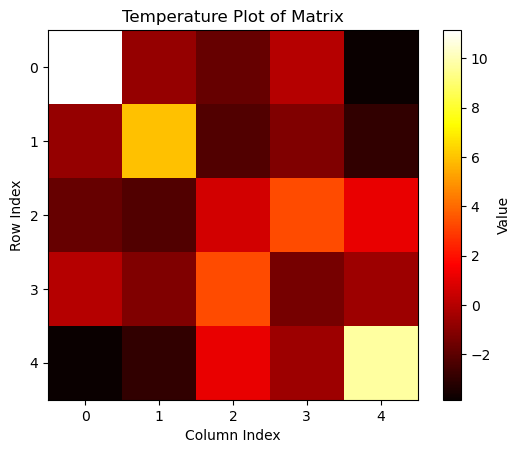

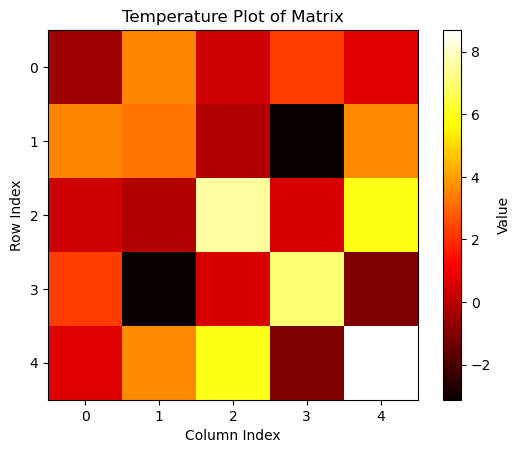

array([-0.48304949,  3.24449971,  7.5399703 ,  7.01052335,  8.68805613])

In [14]:
A_k = QR_eigenvalues_algorithm(A)
A_k